# Airbnb Data Analysis: 
## Making your house the best at the platform!
---
This notebook is part of the Udacity's Data Scientist Nanodegree program

In this project, I will be investigating Airbnb data and answering relevant questions using the **CRISP-DM** process:

1. Business Understanding
2. Data Understanding
3. Data Preparation 
4. Data Modeling
5. Results & Evaluation

# 1. Business Understanding

## The 3 questions I'm looking to answer are:

1. **What are the main features that influences the review rates? What about the prices?**
2. **Which city has the best listings? Which one has more expensive ones? Is there a connection in that?**
3. **Are the best listings generally often occupied? What kind of listings have are the most searched ones?**

# 2. Data Understanding

## 2.1 Importing Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import warnings
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder, normalize
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

pd.set_option('display.max_columns', 500)
warnings.filterwarnings(action='ignore')
%matplotlib inline

## 2.2 Reading Data
### 2.2.1 Boston Airbnb Data

In [2]:
# reading boston data
df_bos_lis = pd.read_csv('BostonData/listings.csv')
df_bos_rev = pd.read_csv('BostonData/reviews.csv')
df_bos_cal = pd.read_csv('BostonData/calendar.csv')

### 2.2.2 Seattle Airbnb Data

In [3]:
# reading seattle data
df_sea_lis = pd.read_csv('SeattleData/listings.csv')
df_sea_rev = pd.read_csv('SeattleData/reviews.csv')
df_sea_cal = pd.read_csv('SeattleData/calendar.csv')

### 2.2.3 First View

In [4]:
display(df_bos_cal.head(), df_sea_cal.head())

,listing_id,date,available,price
0,12147973,2017-09-05,f,NaN
1,12147973,2017-09-04,f,NaN
2,12147973,2017-09-03,f,NaN
3,12147973,2017-09-02,f,NaN
4,12147973,2017-09-01,f,NaN


,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


In [5]:
display(df_bos_lis.head(1), df_sea_lis.head(1))

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,12147973,https://www.airbnb.com/rooms/12147973,20160906204935,2016-09-07,Sunny Bungalow in the City,"Cozy, sunny, family home. Master bedroom high...",The house has an open and cozy feel at the sam...,"Cozy, sunny, family home. Master bedroom high...",none,"Roslindale is quiet, convenient and friendly. ...",NaN,"The bus stop is 2 blocks away, and frequent. B...","You will have access to 2 bedrooms, a living r...",NaN,Clean up and treat the home the way you'd like...,https://a2.muscache.com/im/pictures/c0842db1-e...,https://a2.muscache.com/im/pictures/c0842db1-e...,https://a2.muscache.com/im/pictures/c0842db1-e...,https://a2.muscache.com/im/pictures/c0842db1-e...,31303940,https://www.airbnb.com/users/show/31303940,Virginia,2015-04-15,"Boston, Massachusetts, United States",We are country and city connecting in our deck...,NaN,NaN,NaN,f,https://a2.muscache.com/im/pictures/5936fef0-b...,https://a2.muscache.com/im/pictures/5936fef0-b...,Roslindale,1,1,"['email', 'phone', 'facebook', 'reviews']",t,f,"Birch Street, Boston, MA 02131, United States",Roslindale,Roslindale,NaN,Boston,MA,02131,Boston,"Boston, MA",US,United States,42.282619,-71.133068,t,House,Entire home/apt,4,1.5,2.0,3.0,Real Bed,"{TV,""Wireless Internet"",Kitchen,""Free Parking ...",NaN,$250.00,NaN,NaN,NaN,$35.00,1,$0.00,2,1125,2 weeks ago,NaN,0,0,0,0,2016-09-06,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,NaN,NaN,f,moderate,f,f,1,NaN


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,NaN,NaN,NaN,NaN,https://a1.muscache.com/ac/pictures/67560560/c...,NaN,956883,https://www.airbnb.com/users/show/956883,Maija,2011-08-11,"Seattle, Washington, United States","I am an artist, interior designer, and run a s...",within a few hours,96%,100%,f,https://a0.muscache.com/ac/users/956883/profil...,https://a0.muscache.com/ac/users/956883/profil...,Queen Anne,3.0,3.0,"['email', 'phone', 'reviews', 'kba']",t,t,"Gilman Dr W, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,Seattle,"Seattle, WA",US,United States,47.636289,-122.371025,t,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",NaN,$85.00,NaN,NaN,NaN,NaN,2,$5.00,1,365,4 weeks ago,t,14,41,71,346,2016-01-04,207,2011-11-01,2016-01-02,95.0,10.0,10.0,10.0,10.0,9.0,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07


In [6]:
display(df_bos_rev.head(), df_sea_rev.head())

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,1178162,4724140,2013-05-21,4298113,Olivier,My stay at islam's place was really cool! Good...
1,1178162,4869189,2013-05-29,6452964,Charlotte,Great location for both airport and city - gre...
2,1178162,5003196,2013-06-06,6449554,Sebastian,We really enjoyed our stay at Islams house. Fr...
3,1178162,5150351,2013-06-15,2215611,Marine,The room was nice and clean and so were the co...
4,1178162,5171140,2013-06-16,6848427,Andrew,Great location. Just 5 mins walk from the Airp...


,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...


# 3. Data Preparation

## 3.1 Reviews Dataset
My objective with this dataset is to classify each review as good or bad. Then, I'll count how many good and bad reviews each listing has. I believe this will be a good parameter for predicting both price and review rating. 

In [7]:
# checking first rows of the dataset
df_bos_rev.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,1178162,4724140,2013-05-21,4298113,Olivier,My stay at islam's place was really cool! Good...
1,1178162,4869189,2013-05-29,6452964,Charlotte,Great location for both airport and city - gre...
2,1178162,5003196,2013-06-06,6449554,Sebastian,We really enjoyed our stay at Islams house. Fr...
3,1178162,5150351,2013-06-15,2215611,Marine,The room was nice and clean and so were the co...
4,1178162,5171140,2013-06-16,6848427,Andrew,Great location. Just 5 mins walk from the Airp...


In [8]:
# making a copy of the original dataset
df_bos_rev_c = df_bos_rev.copy()

# checking the dataset info
df_bos_rev_c.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68275 entries, 0 to 68274
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   listing_id     68275 non-null  int64 
 1   id             68275 non-null  int64 
 2   date           68275 non-null  object
 3   reviewer_id    68275 non-null  int64 
 4   reviewer_name  68275 non-null  object
 5   comments       68222 non-null  object
dtypes: int64(3), object(3)
memory usage: 3.1+ MB


### 3.1.1 Reviews classification process
1. I'll will create two lists, one with positive words and other with negative words. 
2. I'll count how many words of each list are present in each comment
3. The category wich has more words, will be the category of the review

In [9]:
# good words list
positive_words = ['good', 'great', 'amazing', 'perfect', 'nice', 'cool', 'cozy', 'amazing', 'comfortable', 'loved',
                  'enjoyed', 'lovely', 'wonderful', 'fantastic', 'pleasure', 'brilliant', 'pleasant', 'superb',
                  'charming', 'awesome', 'beautiful', 'fun', 'excellent']

# bad words list
negative_words = ['bad', 'terrible', 'horrible', 'uncomfortable', 'dirty', 'cancelled', 'unconvenient', 'never',
                  'hated', 'disliked', 'ugly', 'boring', 'refund', 'exhausted', 'tired','garbage','not acceptable',
                  'refund', 'awful', 'damages', 'never', 'frustrated', 'canceled', 'cancel', 'panic', 'horror',
                  'worst']

# classification function
def classify_good_or_bad(comment):
    # making sure comment is string
    comment = str(comment)
    
    # removing all sorts of punctuation
    for char in string.punctuation:
        comment.replace(char, '')
    
    # make it all lowercase
    comment = comment.lower()
    
    # get all words
    comment = comment.split()
    
    # good words count
    positive_count = 0
    for word in comment:
        if word in positive_words:
            positive_count += 1
            
    # bad words count
    negative_count = 0
    for word in comment:
        if word in negative_words:
            negative_count += 1
            
    # classifying 
    if positive_count > negative_count:
        return 'positive'
    elif positive_count < negative_count:
        return 'negative'
    else:
        return 'unknwon'

### 3.1.2 Creating new good or bad review column

In [10]:
# applying the classification function
df_bos_rev_c['review_cat'] = df_bos_rev_c.comments.apply(classify_good_or_bad)
df_bos_rev_c['review_cat'].value_counts()

positive    53084
unknwon     13467
negative     1724
Name: review_cat, dtype: int64

### 3.1.3 Dropping unnecessary columns and creating dummy variables

In [11]:
# pulling only the necessary columns
df_bos_rev_c = df_bos_rev_c[['listing_id', 'review_cat']]

# creating dummy variables for the good, bad or unknown reviews 
df_bos_rev_c = pd.concat([df_bos_rev_c['listing_id'], pd.get_dummies(df_bos_rev_c['review_cat'], prefix='review')], axis=1)
df_bos_rev_c.head()

,listing_id,review_negative,review_positive,review_unknwon
0,1178162,0,1,0
1,1178162,0,1,0
2,1178162,0,1,0
3,1178162,0,1,0
4,1178162,0,1,0


### 3.1.4 Creating the boston reviews dataframe

In [12]:
# creating the boston reviews dataframe by grouping the amount of positive rows by listing_id
boston_reviews = df_bos_rev_c.groupby(['listing_id']).sum().reset_index()
boston_reviews.head()

,listing_id,review_negative,review_positive,review_unknwon
0,3353,0.0,27.0,7.0
1,5506,0.0,30.0,6.0
2,6695,0.0,40.0,7.0
3,6976,1.0,36.0,4.0
4,8792,0.0,17.0,1.0


**This looks great! Later I'll combine this as features in the final dataframe!**

## 3.2 Calendar Dataset
My objective with this dataset is to extract the percentage of the year that each listing was occupied. That way I will be able to explore how the listings features make them more or less attractive to travelers.

In [13]:
# creating a copy of the dataset
df_bos_cal_c = df_bos_cal.copy()

# checking dataset info
df_bos_cal_c.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1308890 entries, 0 to 1308889
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   listing_id  1308890 non-null  int64 
 1   date        1308890 non-null  object
 2   available   1308890 non-null  object
 3   price       643037 non-null   object
dtypes: int64(1), object(3)
memory usage: 39.9+ MB


### 3.2.1 Pulling only necessary columns

In [14]:
# pulling only the listing and availble columns 
df_bos_cal_c = df_bos_cal_c[['listing_id', 'available']]
df_bos_cal_c.head()

,listing_id,available
0,12147973,f
1,12147973,f
2,12147973,f
3,12147973,f
4,12147973,f


### 3.2.2 Formatting the 'available' column

In [15]:
df_bos_cal_c.available.value_counts()

f    665853
t    643037
Name: available, dtype: int64

In [16]:
# applying lambda function to make true of false
df_bos_cal_c.available = df_bos_cal_c.available.apply(lambda x: x == 't')
df_bos_cal_c.head()

,listing_id,available
0,12147973,False
1,12147973,False
2,12147973,False
3,12147973,False
4,12147973,False


In [17]:
df_bos_cal_c.available.value_counts()

False    665853
True     643037
Name: available, dtype: int64

### 3.2.3 Getting the Dummies for the 'available' column

In [18]:
df_bos_cal_c = pd.concat([df_bos_cal_c.listing_id, pd.get_dummies(df_bos_cal_c.available, prefix='available')], axis=1)
df_bos_cal_c.head()

,listing_id,available_False,available_True
0,12147973,1,0
1,12147973,1,0
2,12147973,1,0
3,12147973,1,0
4,12147973,1,0


### 3.2.4 Creating the Boston Calendar dataframe

In [19]:
# grouping the amount of occupied and taken days for each listing
boston_calendar = df_bos_cal_c.groupby('listing_id').sum().reset_index().head()
boston_calendar.head()

,listing_id,available_False,available_True
0,3353,116.0,249.0
1,5506,21.0,344.0
2,6695,41.0,324.0
3,6976,46.0,319.0
4,8792,117.0,248.0


In [20]:
# creating the occupation_rate column: represents the % of the year that the listing is occupied
boston_calendar['occupation_rate'] = boston_calendar['available_False'] / 365

# removing unnecessary columns
boston_calendar = boston_calendar[['listing_id', 'occupation_rate']]
boston_calendar.head()

,listing_id,occupation_rate
0,3353,0.317808
1,5506,0.057534
2,6695,0.112329
3,6976,0.126027
4,8792,0.320548


That looks **amazing**!

## 3.3 Listings Dataset
My objective with this dataset is to get the main features of each listing and it's review status. That way, I'll be able to run a model to predict the listing price and the review rate.

In [21]:
# creating copy of the dataset
df_bos_lis_c = df_bos_lis.copy()

### 3.3.1 Keeping only necessary columns

In [22]:
# selecting only necessary columns
df_bos_lis_c = df_bos_lis_c[['id', 'market', 'host_is_superhost', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 
                             'bed_type', 'amenities', 'price', 'cleaning_fee', 'number_of_reviews', 'review_scores_rating', 'cancellation_policy']]

df_bos_lis_c.head(3)

,id,market,host_is_superhost,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,cleaning_fee,number_of_reviews,review_scores_rating,cancellation_policy
0,12147973,Boston,f,House,Entire home/apt,4,1.5,2.0,3.0,Real Bed,"{TV,""Wireless Internet"",Kitchen,""Free Parking ...",$250.00,$35.00,0,NaN,moderate
1,3075044,Boston,f,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",""Air Conditio...",$65.00,$10.00,36,94.0,moderate
2,6976,Boston,t,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",""Wireless Internet"",""Air Condit...",$65.00,NaN,41,98.0,moderate


### 3.3.2 Checking data types

In [23]:
# checking info of the dataset
df_bos_lis_c.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3585 entries, 0 to 3584
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    3585 non-null   int64  
 1   market                3571 non-null   object 
 2   host_is_superhost     3585 non-null   object 
 3   property_type         3582 non-null   object 
 4   room_type             3585 non-null   object 
 5   accommodates          3585 non-null   int64  
 6   bathrooms             3571 non-null   float64
 7   bedrooms              3575 non-null   float64
 8   beds                  3576 non-null   float64
 9   bed_type              3585 non-null   object 
 10  amenities             3585 non-null   object 
 11  price                 3585 non-null   object 
 12  cleaning_fee          2478 non-null   object 
 13  number_of_reviews     3585 non-null   int64  
 14  review_scores_rating  2772 non-null   float64
 15  cancellation_policy  

Let's check the 'object' type columns to see if any of them should be a numerical one

In [24]:
# pulling only the 'object' type column 
df_bos_lis_c.select_dtypes(include=['object']).head(1)

,market,host_is_superhost,property_type,room_type,bed_type,amenities,price,cleaning_fee,cancellation_policy
0,Boston,f,House,Entire home/apt,Real Bed,"{TV,""Wireless Internet"",Kitchen,""Free Parking ...",$250.00,$35.00,moderate


Ok, so there are 2 columns that should be numerical: 'price' and 'cleaning_fee'. **Let's fix them:**

In [25]:
# applying the functions
df_bos_lis_c.price = df_bos_lis_c.price.apply(lambda x: x.replace('$', ''))
df_bos_lis_c.price = df_bos_lis_c.price.apply(lambda x: x.replace(',', '.'))
df_bos_lis_c.price = df_bos_lis_c.price.apply(lambda x: x[:-3])

df_bos_lis_c.cleaning_fee = df_bos_lis_c.cleaning_fee.apply(lambda x: str(x) if x else None)
df_bos_lis_c.cleaning_fee = df_bos_lis_c.cleaning_fee.apply(lambda x: x.replace('$', '') if x else None)
df_bos_lis_c.cleaning_fee = df_bos_lis_c.cleaning_fee.apply(lambda x: x.replace(',', '.') if x else None)
df_bos_lis_c.cleaning_fee = df_bos_lis_c.cleaning_fee.apply(lambda x: x[:-3] if x else None)
df_bos_lis_c.cleaning_fee = df_bos_lis_c.cleaning_fee.apply(lambda x: np.nan if x=='' else x)

# checking columns
df_bos_lis_c[['price', 'cleaning_fee']].head(3)

,price,cleaning_fee
0,250,35
1,65,10
2,65,NaN


**OK**, they look alright. Now I can fix the datatypes!

In [26]:
# Changing the datatypes 
df_bos_lis_c[['price', 'cleaning_fee']] = df_bos_lis_c[['price', 'cleaning_fee']].astype('float64')
df_bos_lis_c[['price', 'cleaning_fee']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3585 entries, 0 to 3584
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         3585 non-null   float64
 1   cleaning_fee  2478 non-null   float64
dtypes: float64(2)
memory usage: 56.1 KB


### 3.3.3 Dealing with null values

In [27]:
# checking the amount of nulls in each column
df_bos_lis_c.isnull().sum()

id                         0
market                    14
host_is_superhost          0
property_type              3
room_type                  0
accommodates               0
bathrooms                 14
bedrooms                  10
beds                       9
bed_type                   0
amenities                  0
price                      0
cleaning_fee            1107
number_of_reviews          0
review_scores_rating     813
cancellation_policy        0
dtype: int64

### Handling nulls in categorical columns:

In [28]:
# checking the amount of nulls in each object column  
df_bos_lis_c.select_dtypes(include=['object']).isnull().sum()

market                 14
host_is_superhost       0
property_type           3
room_type               0
bed_type                0
amenities               0
cancellation_policy     0
dtype: int64

#### How am I approaching this:
* **Market**: all of them should be 'Boston' so I'll just put that 
* **Property_type**: Since it's only 3, I'll fill them with the mode

In [29]:
# filling market nulls
df_bos_lis_c.market = df_bos_lis_c.market.fillna('Boston')

# filling property_type nulls
df_bos_lis_c.property_type = df_bos_lis_c.property_type.fillna(df_bos_lis_c.property_type.mode().values[0])

# making sure there are no more nulls
df_bos_lis_c.select_dtypes(include=['object']).isnull().sum()

market                 0
host_is_superhost      0
property_type          0
room_type              0
bed_type               0
amenities              0
cancellation_policy    0
dtype: int64

### Handling nulls in numerical columns:

In [30]:
# checking the amount of nulls in each numerical column
df_bos_lis_c.select_dtypes(include=['int64', 'float64']).isnull().sum()

id                         0
accommodates               0
bathrooms                 14
bedrooms                  10
beds                       9
price                      0
cleaning_fee            1107
number_of_reviews          0
review_scores_rating     813
dtype: int64

#### How am I approaching this:

**bathrooms, bedrooms and beds**: Since there are only a handfull of these missing and calculating their mean doesn't make a lot of sense, I'll fill the null values with the mode.


In [31]:
# filling bathrooms null values with the mode
df_bos_lis_c['bathrooms'] = df_bos_lis_c['bathrooms'].fillna(df_bos_lis_c['bathrooms'].mode().values[0])

# filling bedrooms null values with the mode
df_bos_lis_c['bedrooms'] = df_bos_lis_c['bedrooms'].fillna(df_bos_lis_c['bedrooms'].mode().values[0])

# filling beds null values with the mode
df_bos_lis_c['beds'] = df_bos_lis_c['beds'].fillna(df_bos_lis_c['beds'].mode().values[0])

# making sure it worked
df_bos_lis_c[['bathrooms', 'bedrooms', 'beds']].isnull().sum()

bathrooms    0
bedrooms     0
beds         0
dtype: int64

**cleaning_fee**: By looking at the below chart it get's clear that it's better to fill the null values with the mean =~ 68. 

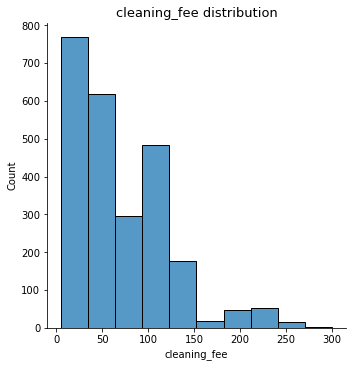

In [32]:
sns.displot(df_bos_lis_c['cleaning_fee'], bins=10)
plt.title('cleaning_fee distribution', size=13)
plt.show()

In [33]:
# filling the null values with the mean 
df_bos_lis_c['cleaning_fee'] = df_bos_lis_c['cleaning_fee'].fillna(df_bos_lis_c['cleaning_fee'].mean())

# checking if it worked
df_bos_lis_c['cleaning_fee'].isnull().sum()

0

### 3.3.4 Dealing with Categorical Features

In [34]:
df_bos_lis_c.select_dtypes(include='object').head()

,market,host_is_superhost,property_type,room_type,bed_type,amenities,cancellation_policy
0,Boston,f,House,Entire home/apt,Real Bed,"{TV,""Wireless Internet"",Kitchen,""Free Parking ...",moderate
1,Boston,f,Apartment,Private room,Real Bed,"{TV,Internet,""Wireless Internet"",""Air Conditio...",moderate
2,Boston,t,Apartment,Private room,Real Bed,"{TV,""Cable TV"",""Wireless Internet"",""Air Condit...",moderate
3,Boston,f,House,Private room,Real Bed,"{TV,Internet,""Wireless Internet"",""Air Conditio...",moderate
4,Boston,t,House,Private room,Real Bed,"{Internet,""Wireless Internet"",""Air Conditionin...",flexible


**market**: I'll just create a 'boston' column that contains 1 for all values in boston

In [35]:
# creates new column based on market column
df_bos_lis_c['boston'] = np.where(df_bos_lis_c['market']=='Boston', 1, 0)

# drops olde market column
df_bos_lis_c.drop('market', axis=1, inplace=True)

# shows boston column
df_bos_lis_c['boston'].head()

0    1
1    1
2    1
3    1
4    1
Name: boston, dtype: int64

**host_is_superhost**: I'll again just create a new column 'superhost' that contains 1 if true else 0

In [36]:
# creates new column superhost based on host_is_superhost column
df_bos_lis_c['superhost'] = np.where(df_bos_lis_c['host_is_superhost']=='t', 1, 0)

# drop the 'host_is_superhost' column
df_bos_lis_c.drop('host_is_superhost', axis=1, inplace=True)

# shows superhost column
df_bos_lis_c['superhost'].head()


0    0
1    0
2    1
3    0
4    1
Name: superhost, dtype: int64

**property_type**: I'll get the dummies for this column

In [37]:
df_bos_lis_c = pd.concat([df_bos_lis_c.drop('property_type',axis=1), pd.get_dummies(df_bos_lis_c.property_type)], axis=1)
df_bos_lis_c.head()

,id,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,cleaning_fee,number_of_reviews,review_scores_rating,cancellation_policy,boston,superhost,Apartment,Bed & Breakfast,Boat,Camper/RV,Condominium,Dorm,Entire Floor,Guesthouse,House,Loft,Other,Townhouse,Villa
0,12147973,Entire home/apt,4,1.5,2.0,3.0,Real Bed,"{TV,""Wireless Internet"",Kitchen,""Free Parking ...",250.0,35.000000,0,NaN,moderate,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,3075044,Private room,2,1.0,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",""Air Conditio...",65.0,10.000000,36,94.0,moderate,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,6976,Private room,2,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",""Wireless Internet"",""Air Condit...",65.0,68.380145,41,98.0,moderate,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0
3,1436513,Private room,4,1.0,1.0,2.0,Real Bed,"{TV,Internet,""Wireless Internet"",""Air Conditio...",75.0,50.000000,1,100.0,moderate,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,7651065,Private room,2,1.5,1.0,2.0,Real Bed,"{Internet,""Wireless Internet"",""Air Conditionin...",79.0,15.000000,29,99.0,flexible,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0


**room_type**: I'll also just get the dummies for this one

In [38]:
df_bos_lis_c = pd.concat([df_bos_lis_c.drop('room_type',axis=1), pd.get_dummies(df_bos_lis_c.room_type)], axis=1)
df_bos_lis_c.head()

,id,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,cleaning_fee,number_of_reviews,review_scores_rating,cancellation_policy,boston,superhost,Apartment,Bed & Breakfast,Boat,Camper/RV,Condominium,Dorm,Entire Floor,Guesthouse,House,Loft,Other,Townhouse,Villa,Entire home/apt,Private room,Shared room
0,12147973,4,1.5,2.0,3.0,Real Bed,"{TV,""Wireless Internet"",Kitchen,""Free Parking ...",250.0,35.000000,0,NaN,moderate,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
1,3075044,2,1.0,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",""Air Conditio...",65.0,10.000000,36,94.0,moderate,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,6976,2,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",""Wireless Internet"",""Air Condit...",65.0,68.380145,41,98.0,moderate,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,1436513,4,1.0,1.0,2.0,Real Bed,"{TV,Internet,""Wireless Internet"",""Air Conditio...",75.0,50.000000,1,100.0,moderate,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
4,7651065,2,1.5,1.0,2.0,Real Bed,"{Internet,""Wireless Internet"",""Air Conditionin...",79.0,15.000000,29,99.0,flexible,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
